# Example 1D: Double-Well potential system

In [1]:
# Load basic modules.
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep

In [2]:
# Add the (custom) source code file in the path.
module_path = os.path.abspath(os.path.join('../../src/'))

if module_path not in sys.path:
    sys.path.append(module_path)
# _end_if_

In [3]:
# Load custom modules.
from var_bayes.free_energy import FreeEnergy
from dynamical_systems.double_well import DoubleWell
from numerical.symbolics import get_local_polynomials

In [4]:
# Drift and noise parameter(s).
theta, sigma = 1.0, 0.8

# Create a DoubleWell object.
DW = DoubleWell(sigma, theta, r_seed=180)

In [5]:
# Time-window of inference T = [t0, tf] with step = dt.
t0, tf, dt = 0.0, 10.0, 0.01

# Make a trajectory (discrete sample path).
DW.make_trajectory(t0, tf, dt)

# Observation density.
nobs = 2

# Collect the (noise free) observations.
obs_idk, obs_val = DW.collect_obs(nobs)

In [6]:
# Observation noise (variance).
obs_noise = 0.04

# Add Gaussian I.I.D. noise to the observations.
obs_val += np.sqrt(obs_noise) * DW.rng.standard_normal(obs_val.shape)

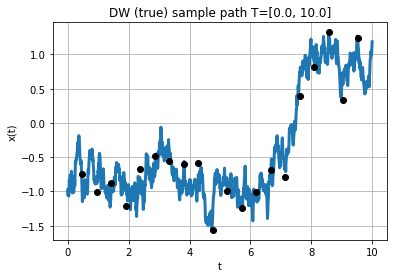

In [7]:
# Quick sample path plot.
plt.plot(DW.tk, DW.xt, linewidth=3)
plt.plot(obs_idk*dt, obs_val, 'ko')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title(f"DW (true) sample path T=[{t0}, {tf}]")
plt.grid(True)

In [8]:
# Note: If it happens to have observations at the initial and final
# times (i.e. t0, tf), then we do not need to extend the following
# vectors "spl_timex" and "spl_value".

# Build the spline with these parameters.
spl_timex = np.array([t0,
                      *(obs_idk*dt),
                      tf])

spl_value = np.array([obs_val[0],
                      *obs_val,
                      obs_val[-1]])

# Create the initial sample path (t=0) using
# cubic B-splines at the noisy observations.
B_spline_cubic = splrep(spl_timex, spl_value, k=3)

# Evaluate the B-spline at the whole time-window 'tk'.
x0 = splev(DW.tk, B_spline_cubic)

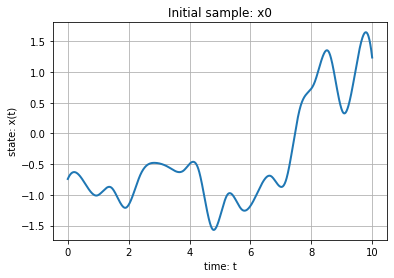

In [9]:
plt.plot(DW.tk, x0, linewidth=2)
plt.title("Initial sample: x0")
plt.xlabel("time: t")
plt.ylabel("state: x(t)")
plt.grid(True)

In [10]:
# This time space is in index-units.
time_space = [0, *obs_idk, len(x0)-1]

mp_idk = []
sp_idk = []

for n, tn in enumerate(time_space):
    
    # Avoids out of bounds.
    if tn == time_space[-1]:
        break
    # _end_if_
    
    # Take every 4 instances.
    mp_idk.extend(np.linspace(time_space[n], time_space[n+1],
                              num=4, endpoint=True, dtype=int))
    
    # Take every 3 instances.
    sp_idk.extend(np.linspace(time_space[n], time_space[n+1],
                              num=3, endpoint=True, dtype=int))
# _end_for_

# Remove the duplicates (at observation points).
mp_idk = np.unique(mp_idk)
sp_idk = np.unique(sp_idk)

In [11]:
# Initial mean points.
mp_t0 = x0[mp_idk]

# Initialize variance points.
sp_t0 =  0.25 * np.ones(len(sp_idk))

# Perturb with some positive noise.
sp_t0 += 0.1 * np.random.rand(*sp_t0.shape)

# Put the variance in log-space.
sp_t0 = np.log(sp_t0)

In [12]:
# Initial prior moments for N(mu0, tau0).
mu0, tau0 = 1.0, 0.25

# Create a FreeEnergy object.
free_energy = FreeEnergy(DW, mu0, tau0, obs_idk*dt, obs_val, obs_noise)

In [20]:
# Run the optimization.
opt_res = free_energy.find_minimum(np.concatenate((mp_t0.flatten(order='C'),
                                                   sp_t0.flatten(order='C')), axis=0),
                                   maxiter=500, check_gradients=True, verbose=True)

Grad-Check |BEFORE| minimization ...
 > Error = 2.709E-05
------------------------------------

SCG: Optimization started ...
It=     0: F(x)= 2.606E+02 -/- Sum(Gradients)= 2.374E+03
It=    50: F(x)= 1.443E+01 -/- Sum(Gradients)= 1.844E+00
It=   100: F(x)= 1.440E+01 -/- Sum(Gradients)= 5.606E-01
 Elapsed time: 42.69 seconds.

Grad-Check |AFTER| minimization ...
 > Error = 3.271E-06
------------------------------------

Done!


In [14]:
# Unpack the optimization results.
opt_x, opt_fx, opt_stats = opt_res

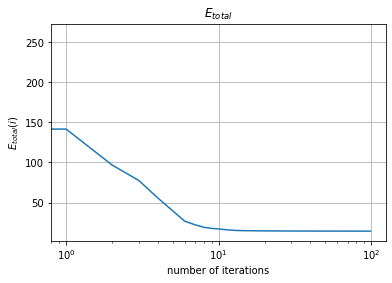

In [15]:
# Plot the energy values.
plt.semilogx(opt_stats["fx"][0:opt_stats["MaxIt"]])
plt.title("$E_{total}$")
plt.xlabel("number of iterations")
plt.ylabel("$E_{total}(i)$")
plt.grid();

In [16]:
# Get the mean points.
mp_tf = opt_x[0:mp_t0.size]

# Get the variance points. Remember that they
# are in log-space so here we have to use exp().
sp_tf = np.exp(opt_x[mp_t0.size:])

In [17]:
# Get the lambda functions of the polynomials.
fun_mean_, fun_vars_ = get_local_polynomials()

In [18]:
# Empty lists for the output functions.
tt, mt, st = [], [], []

# This time space is in time-units.
Tx = [t0, *(dt*obs_idk), tf]

# Reconstruct the mean and variance functions.
for n in range(0, len(Tx)-1):
    
    # Take the limits of the time interval.
    ti, tj = Tx[n], Tx[n+1]
        
    # It should be the same for equally spaced oservations.
    delta_t = np.abs(tj-ti)
    
    # Spacing variables fot the polynomials.
    h = float(delta_t/3.0)
    c = float(delta_t/2.0)
    
    # Extract variables for efficiency.
    nth_mean_points = mp_tf[(3 * n): (3 * n) + 4]
    nth_vars_points = sp_tf[(2 * n): (2 * n) + 3]
    
    # Prepare the parameters of the Lagrange polynomials.
    par_m = [ti, ti + h, ti + (2 * h), ti + (3 * h), *nth_mean_points]
    par_s = [ti, ti + c, ti + (2 * c), *nth_vars_points]
    
    # Since the functions are continous we can generate
    # as many m(t) and s(t) as we want. Here we collect
    # num points.
    for t in np.linspace(ti, tj, num=80, endpoint=False):
        
        mt.append(fun_mean_(t, *par_m))
        st.append(fun_vars_(t, *par_s))
        tt.append(t)
        
    # _end_for_
    
# _end_for_

# Add the final point 'tf'.
mt.append(fun_mean_(tf, *par_m))
st.append(fun_vars_(tf, *par_s))
tt.append(tf)

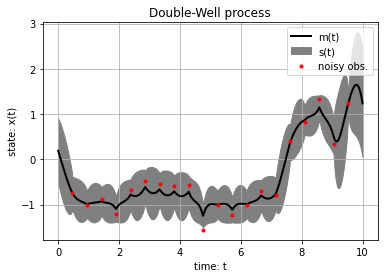

In [19]:
# Convert everything to numpy arrays.
tt = np.array(tt)
mt = np.array(mt)
st = np.array(st)

# Sample mean.
plt.plot(tt, mt, 'k-', label="m(t)", linewidth=2)

# Sample 2xStd (filled envelope).
plt.fill_between(tt, mt - 2.0*np.sqrt(st), mt + 2.0*np.sqrt(st),
                 label="s(t)", color="gray")

# Noisy observations.
plt.plot(obs_idk*dt, obs_val, 'ro', markersize=3, label="noisy obs.")

# Title and more.
plt.title("Double-Well process")
plt.xlabel("time: t")
plt.ylabel("state: x(t)")
plt.grid(True)
plt.legend(loc="best");